<a href="https://colab.research.google.com/github/rajgurubhosale/Resale-car-price-prediction/blob/main/model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.preprocessing import FunctionTransformer,PowerTransformer

In [35]:
df = pd.read_csv('/content/drive/MyDrive/used car price/clean_df.csv')
df.shape

(17128, 11)

In [36]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [37]:
df.head(2)

,full_name,engine_capacity,resale_price,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand
0,Baleno 1.2,1197.0,545000.0,2017,Third,Manual,40000.0,First,Petrol,Maruti
1,Hexa XTA,2179.0,1000000.0,2018,Third,Automatic,70000.0,First,Diesel,Tata


In [38]:
#adding new feature
df['age'] = df['registered_year'].max() - df['registered_year']

In [39]:
df.head(4)

,full_name,engine_capacity,resale_price,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand,age
0,Baleno 1.2,1197.0,545000.0,2017,Third,Manual,40000.0,First,Petrol,Maruti,6
1,Hexa XTA,2179.0,1000000.0,2018,Third,Automatic,70000.0,First,Diesel,Tata,5


In [40]:
X = df.drop(columns=['resale_price'])
y = df['resale_price']

In [41]:
X_train , X_test , y_train ,y_test = train_test_split(X,y,test_size=0.2,random_state=75)

In [42]:
y_train.shape , y_test.shape ,X_train.shape , X_test.shape

((13702,), (3426,), (13702, 10), (3426, 10))

In [43]:
fn = FunctionTransformer(np.log)
y_train = fn.fit_transform(y_train)
y_test = fn.transform(y_test)

In [44]:
X_train.head(2)

,full_name,engine_capacity,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand,age
12603,Santro Xing,1086.0,2011,First,Manual,57757.0,Second,Petrol,Hyundai,12
15422,Swift VDI,1248.0,2012,First,Manual,70000.0,First,Diesel,Maruti,11


#Feature Engineering

In [45]:
before_wins= X_train['kms_driven'].copy()

upper = X_train['kms_driven'].quantile(0.99)
lower = X_train['kms_driven'].quantile(0.01)
X_train['kms_driven'] = np.where(X_train['kms_driven'] > upper,upper,X_train['kms_driven'])
X_train['kms_driven'] = np.where(X_train['kms_driven'] < lower,lower,X_train['kms_driven'])


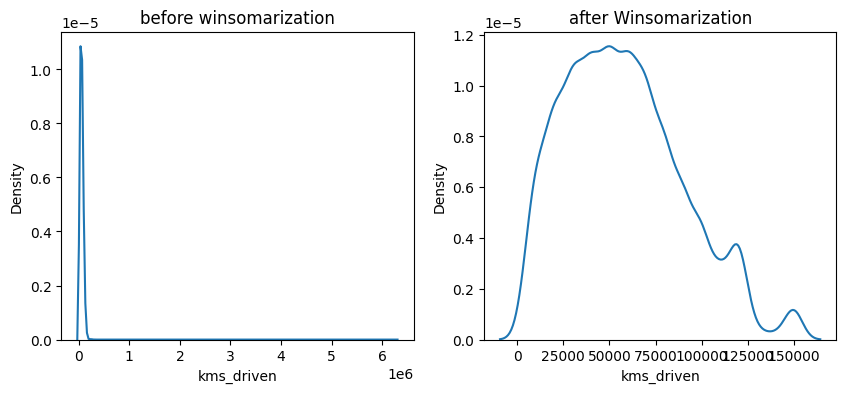

In [47]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('before winsomarization')
sns.kdeplot(before_wins)

plt.subplot(122)
plt.title('after Winsomarization')
sns.kdeplot(X_train['kms_driven'])
plt.show()

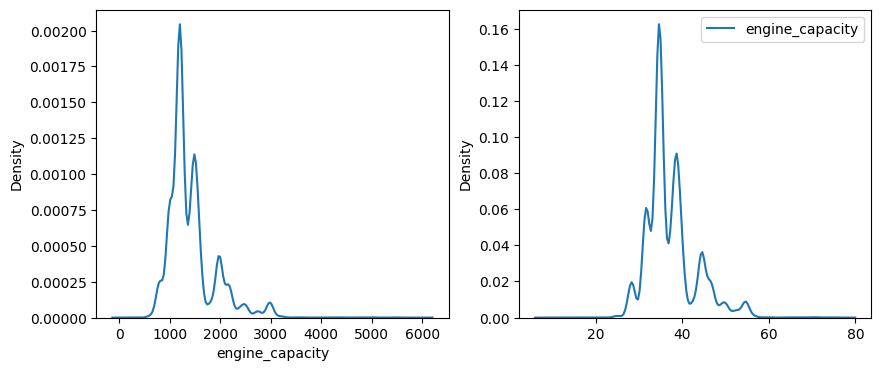

In [48]:
fn = FunctionTransformer(np.sqrt)
a = fn.fit_transform(X_train[['engine_capacity']])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.kdeplot(X_train['engine_capacity'])
plt.subplot(122)
sns.kdeplot(a)
plt.show()

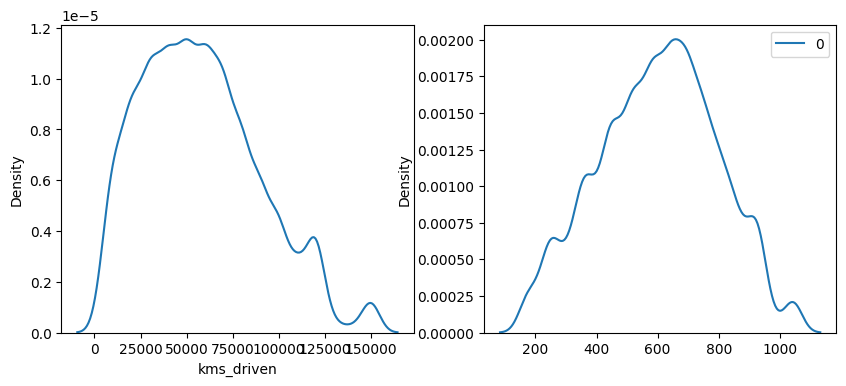

In [65]:
pn = PowerTransformer('yeo-johnson',standardize=False)
a = pn.fit_transform(X_train[['kms_driven']])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.kdeplot(X_train['kms_driven'])
plt.subplot(122)
sns.kdeplot(a)
plt.show()

# Model Building

In [50]:
from sklearn.preprocessing import TargetEncoder
te = TargetEncoder()
te_tnf = Pipeline([
    ('tn',te),
])

year_tnf = Pipeline(steps=[
    ('imput',SimpleImputer(strategy='most_frequent')),
    ('scale',MinMaxScaler())
    ])

yeo_jhonson = PowerTransformer(method='yeo-johnson',standardize=False)
yeo_tnf = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('yeo-jhonson',yeo_jhonson),
    ('scale',MinMaxScaler())
])

engine_tnf = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('fn',FunctionTransformer()),
    ('scale',MinMaxScaler())
])

cat_oe_tnf = Pipeline(steps=[
    ('impute_oe',SimpleImputer(strategy='most_frequent')),
    ('oe',OrdinalEncoder(categories=[['Uncovered','Third','Second','First','Zerodep'],['Fifth','Fourth','Third','Second','First']],handle_unknown='use_encoded_value',unknown_value=-1) ),

    ])


cat_ohe_tnf = Pipeline(steps=[
    ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore')),
    ])

In [51]:
X_train.head(2)

,full_name,engine_capacity,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand,age
12603,Santro Xing,1086.0,2011,First,Manual,57757.0,Second,Petrol,Hyundai,12
15422,Swift VDI,1248.0,2012,First,Manual,70000.0,First,Diesel,Maruti,11


In [52]:
preprocessor = ColumnTransformer(transformers=[
  ('te',te_tnf,[0]),
  ('year_tnf',year_tnf,[2]),
  ('yeo_jhonson_tnf',yeo_tnf,[5,9]),
  ('engine_tnf',engine_tnf,[1]),
  ('ohe',cat_ohe_tnf,[4,7,8]),
 ('oe',cat_oe_tnf,[3,6]),
  ])

In [53]:
X_train.head(2)

,full_name,engine_capacity,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand,age
12603,Santro Xing,1086.0,2011,First,Manual,57757.0,Second,Petrol,Hyundai,12
15422,Swift VDI,1248.0,2012,First,Manual,70000.0,First,Diesel,Maruti,11


In [54]:
from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
poly = PolynomialFeatures(degree=2)
lr = LinearRegression()
sg = SGDRegressor(max_iter=10000)
rg = Ridge(alpha=0.003)
rf = RandomForestRegressor()
pipe = Pipeline([
    ('tnf',preprocessor),
   ('poly',poly),
    ('model',lr)
])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.9172862946408555

In [55]:
from sklearn.metrics import mean_squared_error
pred = pipe.predict(X_test)
pred = np.round(np.exp(pred))
np.sqrt(mean_squared_error(pred,y_test))

1249836.9307480946

In [56]:
X_train.head(2)

,full_name,engine_capacity,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand,age
12603,Santro Xing,1086.0,2011,First,Manual,57757.0,Second,Petrol,Hyundai,12
15422,Swift VDI,1248.0,2012,First,Manual,70000.0,First,Diesel,Maruti,11


In [58]:
import pickle
pickle.dump(df,open('/content/drive/MyDrive/used car price/df.pkl','wb'))
pickle.dump(pipe,open('/content/drive/MyDrive/used car price/pipe.pkl','wb'))

In [59]:
abs_coef = np.abs(pipe.named_steps['model'].coef_)
top_features_indices = np.argsort(abs_coef)[::-1][:10]
top_features_indices

array([  5,  92,   4, 175, 218, 174,   1,  91, 215, 235])

In [60]:
X_train.head(2)

,full_name,engine_capacity,registered_year,insurance,transmission_type,kms_driven,owner_type,fuel_type,brand,age
12603,Santro Xing,1086.0,2011,First,Manual,57757.0,Second,Petrol,Hyundai,12
15422,Swift VDI,1248.0,2012,First,Manual,70000.0,First,Diesel,Maruti,11


In [61]:
pred = pipe.predict(X_test)
pred = np.round(np.exp(pred))

In [62]:
target =np.round(np.exp(y_test))

In [63]:
temp = pd.DataFrame({
    'predicted': pred,
    'target':target,
    'residual':target - pred
    })

In [64]:
temp.head(5)

,predicted,target,residual
13284,218570.0,220000.0,1430.0
13502,86005.0,70000.0,-16005.0
6013,642721.0,620000.0,-22721.0
11223,262113.0,302000.0,39887.0
9715,1534464.0,1500000.0,-34464.0
